In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/um-game-playing-strength-of-mcts-variants/sample_submission.csv
/kaggle/input/um-game-playing-strength-of-mcts-variants/train.csv
/kaggle/input/um-game-playing-strength-of-mcts-variants/test.csv
/kaggle/input/um-game-playing-strength-of-mcts-variants/concepts.csv
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/mcts_gateway.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/__init__.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/mcts_inference_server.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/core/templates.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/core/base_gateway.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/core/relay.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evalua

In [18]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [19]:
train = import_data('/kaggle/input/um-game-playing-strength-of-mcts-variants/train.csv')
test = import_data('/kaggle/input/um-game-playing-strength-of-mcts-variants/test.csv')
concepts = import_data('/kaggle/input/um-game-playing-strength-of-mcts-variants/concepts.csv')

/tmp/ipykernel_36/147790395.py:42: FutureWarning: The 'keep_date_col' keyword in pd.read_csv is deprecated and will be removed in a future version. Explicitly remove unwanted columns after parsing instead.
  df = pd.read_csv(file, parse_dates=True, keep_date_col=True)


Memory usage of dataframe is 1448.46 MB
Memory usage after optimization is: 259.71 MB
Decreased by 82.1%
Memory usage of dataframe is 0.02 MB


/tmp/ipykernel_36/147790395.py:42: FutureWarning: The 'keep_date_col' keyword in pd.read_csv is deprecated and will be removed in a future version. Explicitly remove unwanted columns after parsing instead.
  df = pd.read_csv(file, parse_dates=True, keep_date_col=True)


Memory usage after optimization is: 0.00 MB
Decreased by 79.1%
Memory usage of dataframe is 0.06 MB
Memory usage after optimization is: 0.12 MB
Decreased by -121.2%


/tmp/ipykernel_36/147790395.py:42: FutureWarning: The 'keep_date_col' keyword in pd.read_csv is deprecated and will be removed in a future version. Explicitly remove unwanted columns after parsing instead.
  df = pd.read_csv(file, parse_dates=True, keep_date_col=True)


In [20]:

train.info()  # Get a summary of the dataset including column types and non-null counts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233234 entries, 0 to 233233
Columns: 814 entries, Id to utility_agent1
dtypes: category(5), float16(170), float32(13), float64(18), int16(12), int32(1), int8(595)
memory usage: 259.7 MB


In [21]:
missing_percentage = train.isnull().mean() * 100
# Drop columns with more than 50% missing values
train = train.drop(columns=missing_percentage[missing_percentage > 50].index)
train.head()

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.070007,18877.169922,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466553
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.070007,18877.169922,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333252
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.070007,18877.169922,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066650
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.070007,18877.169922,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333252
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.070007,18877.169922,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333252


In [22]:
y = train[['utility_agent1']]
X = train.drop('utility_agent1', axis=1)

In [23]:
# Number of unique values in each column
unique_counts = X.nunique()
print(unique_counts)
# Drop columns with only one unique value
X = X.drop(columns=unique_counts[unique_counts == 1].index)
test = test.drop(columns=unique_counts[unique_counts == 1].index)

Id                   233234
GameRulesetName        1377
agent1                   72
agent2                   72
Properties                1
                      ...  
EnglishRules           1328
LudRules               1373
num_wins_agent1          33
num_draws_agent1         31
num_losses_agent1        34
Length: 795, dtype: int64


In [24]:
# Split 'agent1' into 5 parts and assign to new columns
X[['agent1_part1', 'agent1_part2', 'agent1_part3', 'agent1_part4', 'agent1_part5']] = X['agent1'].str.split('-', expand=True)

# Split 'agent2' into 5 parts and assign to new columns
X[['agent2_part1', 'agent2_part2', 'agent2_part3', 'agent2_part4', 'agent2_part5']] = X['agent2'].str.split('-', expand=True)

test[['agent1_part1', 'agent1_part2', 'agent1_part3', 'agent1_part4', 'agent1_part5']] = test['agent1'].str.split('-', expand=True)

# Split 'agent2' into 5 parts and assign to new columns
test[['agent2_part1', 'agent2_part2', 'agent2_part3', 'agent2_part4', 'agent2_part5']] = test['agent2'].str.split('-', expand=True)

X = X.drop(['Id','agent1','agent2'], axis=1)

test = test.drop(['Id','agent1','agent2'], axis=1)

X.head()




/tmp/ipykernel_36/667625448.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[['agent1_part1', 'agent1_part2', 'agent1_part3', 'agent1_part4', 'agent1_part5']] = X['agent1'].str.split('-', expand=True)
/tmp/ipykernel_36/667625448.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[['agent1_part1', 'agent1_part2', 'agent1_part3', 'agent1_part4', 'agent1_part5']] = X['agent1'].str.split('-', expand=True)
/tmp/ipykernel_36/667625448.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

,GameRulesetName,Stochastic,Asymmetric,AsymmetricForces,AsymmetricPiecesType,PlayersWithDirections,Cooperation,Team,Shape,SquareShape,...,agent1_part1,agent1_part2,agent1_part3,agent1_part4,agent1_part5,agent2_part1,agent2_part2,agent2_part3,agent2_part4,agent2_part5
0,00Y,0,0,0,0,0,0,0,1,0,...,MCTS,ProgressiveHistory,0.1,MAST,false,MCTS,ProgressiveHistory,0.6,Random200,false
1,00Y,0,0,0,0,0,0,0,1,0,...,MCTS,ProgressiveHistory,0.1,MAST,false,MCTS,UCB1GRAVE,0.6,NST,true
2,00Y,0,0,0,0,0,0,0,1,0,...,MCTS,ProgressiveHistory,0.1,MAST,true,MCTS,UCB1,0.1,NST,false
3,00Y,0,0,0,0,0,0,0,1,0,...,MCTS,ProgressiveHistory,0.1,MAST,true,MCTS,UCB1,0.6,NST,false
4,00Y,0,0,0,0,0,0,0,1,0,...,MCTS,ProgressiveHistory,0.1,MAST,true,MCTS,UCB1GRAVE,1.41421356237,NST,false


In [25]:
# Select only categorical features and the target\
X = X.drop(['num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1'], axis=1)

categorical_features = X.select_dtypes(include=['object', 'category']).columns

num_feat = X.select_dtypes('number').columns
feature_names = X.columns

In [26]:
X.columns.values

array(['GameRulesetName', 'Stochastic', 'Asymmetric', 'AsymmetricForces',
       'AsymmetricPiecesType', 'PlayersWithDirections', 'Cooperation',
       'Team', 'Shape', 'SquareShape', 'HexShape', 'TriangleShape',
       'DiamondShape', 'RectangleShape', 'SpiralShape', 'CircleShape',
       'StarShape', 'SquarePyramidalShape', 'RegularShape',
       'PolygonShape', 'Tiling', 'SquareTiling', 'HexTiling',
       'TriangleTiling', 'SemiRegularTiling', 'MorrisTiling',
       'CircleTiling', 'ConcentricTiling', 'SpiralTiling',
       'AlquerqueTiling', 'MancalaBoard', 'MancalaStores',
       'MancalaTwoRows', 'MancalaThreeRows', 'MancalaFourRows',
       'MancalaSixRows', 'MancalaCircular', 'AlquerqueBoard',
       'AlquerqueBoardWithOneTriangle', 'AlquerqueBoardWithTwoTriangles',
       'AlquerqueBoardWithFourTriangles',
       'AlquerqueBoardWithEightTriangles', 'ThreeMensMorrisBoard',
       'ThreeMensMorrisBoardWithTwoTriangles', 'NineMensMorrisBoard',
       'StarBoard', 'CrossBoard', '

In [27]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
cat_encoder = OrdinalEncoder()
std = StandardScaler()
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(
    [('cat', cat_encoder, categorical_features), 
     ('std', StandardScaler(), num_feat)]
)
X = ct.set_output(transform='pandas').fit_transform(X)


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
import xgboost as xgb
xgb = xgb.XGBRegressor(random_state=42)
xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], eval_metric='rmse')

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.56437
[1]	validation_0-rmse:0.52498
[2]	validation_0-rmse:0.49979
[3]	validation_0-rmse:0.48364
[4]	validation_0-rmse:0.46999
[5]	validation_0-rmse:0.46108
[6]	validation_0-rmse:0.45313
[7]	validation_0-rmse:0.44387
[8]	validation_0-rmse:0.44004
[9]	validation_0-rmse:0.43004
[10]	validation_0-rmse:0.42254
[11]	validation_0-rmse:0.41530
[12]	validation_0-rmse:0.41009
[13]	validation_0-rmse:0.40452
[14]	validation_0-rmse:0.40344
[15]	validation_0-rmse:0.39968
[16]	validation_0-rmse:0.39693
[17]	validation_0-rmse:0.39279
[18]	validation_0-rmse:0.39059
[19]	validation_0-rmse:0.38908
[20]	validation_0-rmse:0.38786
[21]	validation_0-rmse:0.38674
[22]	validation_0-rmse:0.38367
[23]	validation_0-rmse:0.38150
[24]	validation_0-rmse:0.38027
[25]	validation_0-rmse:0.37842
[26]	validation_0-rmse:0.37628
[27]	validation_0-rmse:0.37526
[28]	validation_0-rmse:0.37315
[29]	validation_0-rmse:0.37035
[30]	validation_0-rmse:0.36820
[31]	validation_0-rmse:0.36765
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [30]:
xgb.score(X_test, y_test)

0.7302425331028055

In [31]:
for col, val in sorted(zip(feature_names, xgb.feature_importances_), key=lambda x: x[1],reverse=True)[:10]:
    print(f'{col:10}{val:10.3f}')

BoardSitesOccupiedChangeLineBestFit     0.055
GoStyle        0.036
CaptureSequenceFrequency     0.025
RightwardDirection     0.024
ThreeMensMorrisBoard     0.024
NoMoves        0.022
SurroundCapture     0.019
PieceDirection     0.018
BranchingFactorChangeMaxIncrease     0.015
DecisionFactorVariance     0.013


In [32]:
import lightgbm as lgb
lgr = lgb.LGBMRegressor(random_state=42)
lgr.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.453950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18459
[LightGBM] [Info] Number of data points in the train set: 186587, number of used features: 599
[LightGBM] [Info] Start training from score 0.043666


LGBMRegressor(random_state=42)

In [33]:
lgr.score(X_test, y_test)

0.652943614837413

In [34]:
# Sort features by importance and keep the top 100
top_features = [col for col, val in sorted(zip(X.columns, lgr.feature_importances_), 
                                           key=lambda x: x[1], reverse=True)[:20]]

# Print feature names and their importance
for col, val in sorted(zip(X.columns, lgr.feature_importances_), key=lambda x: x[1], reverse=True)[:60]:
    print(f'{col:10}{val:10.3f}')

# Select only the top 100 important features from X
X_top_features = X[top_features]


cat__agent2_part2   193.000
cat__agent1_part2   178.000
std__AdvantageP1   120.000
cat__agent1_part4    99.000
cat__agent2_part3    90.000
cat__agent2_part4    87.000
std__GameTreeComplexity    84.000
cat__agent1_part3    71.000
std__DurationTurnsNotTimeouts    71.000
std__OutcomeUniformity    70.000
std__PlayoutsPerSecond    70.000
cat__GameRulesetName    66.000
std__DurationActions    57.000
std__MovesPerSecond    50.000
std__DurationTurnsStdDev    41.000
std__BranchingFactorAverage    41.000
std__DurationMoves    38.000
std__HopCaptureFrequency    36.000
std__DecisionMoves    36.000
std__BranchingFactorMedian    36.000
cat__EnglishRules    34.000
std__DecisionFactorMedian    33.000
std__StateTreeComplexity    32.000
std__DecisionFactorChangeSign    26.000
std__BoardSitesOccupiedMaxIncrease    25.000
std__BranchingFactorVariance    25.000
std__DrawFrequency    24.000
std__BoardSitesOccupiedMaximum    23.000
std__BoardSitesOccupiedChangeSign    23.000
std__BranchingFactorMaximum    22

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 186587, number of used features: 20
[LightGBM] [Info] Start training from score 0.052740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2622
[LightGBM] [Info] Number of data points in the train set: 186587, number of used features: 19
[LightGBM] [Info] Start training from score 0.052740
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

RFECV(ax=<Axes: >, cv=5, estimator=LGBMRegressor())

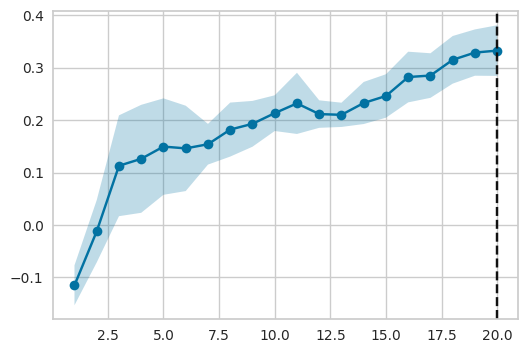

In [35]:
import matplotlib.pyplot as plt
from yellowbrick.features import RFECV
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
fig, ax = plt.subplots(figsize=(6,4))
rfe = RFECV(lgb.LGBMRegressor(), cv=5)
rfe.fit(X_top_features, y)

In [36]:
rfe.rfe_estimator_.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [37]:
rfe.rfe_estimator_.n_features_

20

In [38]:
rfe.rfe_estimator_.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [39]:
from sklearn.feature_selection import RFE
model = lgb.LGBMRegressor()
rfe = RFE(estimator=model, n_features_to_select=3)
rfe.fit(X_top_features,y)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2891
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 20
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2636
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 19
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2633
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 18
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2630
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 17
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 16
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 15
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 14
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2504
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 13
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2249
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 12
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2146
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 11
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 10
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1887
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 9
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1632
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 8
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 7
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 6
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1118
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 5
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 4
[LightGBM] [Info] Start training from score 0.044396


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 3
[LightGBM] [Info] Start training from score 0.044396


RFE(estimator=LGBMRegressor(), n_features_to_select=3)

In [40]:
X_top_features.columns[rfe.support_]

Index(['std__AdvantageP1', 'std__GameTreeComplexity',
       'std__DurationTurnsNotTimeouts'],
      dtype='object')

In [41]:
X_top_features1 = X[X_top_features.columns[rfe.support_]]

In [42]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10)
s = cross_val_score(lgr, X_top_features1, y, cv=kfold)
s

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 209910, number of used features: 3
[LightGBM] [Info] Start training from score 0.046963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 209910, number of used features: 3
[LightGBM] [Info] Start training from score 0.049252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

array([0.21890037, 0.12896053, 0.02839584, 0.09455188, 0.5467655 ,
       0.37370933, 0.07183015, 0.09164571, 0.08958556, 0.05942924])

In [48]:
def train_model():
    from sklearn.decomposition import PCA
    global pca, lgbm_reg
# Reduce to 100 principal components
    pca = PCA(n_components=100)
    X_pca = pca.fit_transform(X)
    X_train, X_valid, y_train, y_valid = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    import lightgbm as lgb
    lgbm_reg = lgb.LGBMRegressor(
        learning_rate=0.05,
        num_leaves=50,
        n_estimators=1500,
        min_child_samples=42,
        subsample=0.8,
        colsample_bytree=0.9,
        reg_alpha=0.001,
        reg_lambda=0.02,
        min_split_gain=0.001,
        min_child_weight=0.002)        # Use GPU for faster training
    
    lgbm_reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    y_predict = lgbm_reg.predict(X_valid)

# Evaluate the model
    from sklearn.metrics import mean_squared_error
    import numpy as np

# Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_valid, y_predict))
    print(f'Validation RMSE: {rmse:.4f}')

In [47]:
def predict(test):
    global counter

    if counter == 0:
        train_model()

    counter += 1

    # Step 1: Drop columns with too many missing values
    test = test.drop(columns=missing_percentage[missing_percentage > 50].index)

    # Step 2: Transform categorical/numerical features
    test = ct.transform(test)

    # Step 3: Handle inf or NaN values before PCA
    test = np.array(test)
    test[np.isinf(test)] = np.nan
    test = np.nan_to_num(test, nan=np.nanmedian(test, axis=0))

    # Step 4: PCA transform
    test = pca.transform(test)

    # Step 5: Predict using trained model
    predictions = lgbm_reg.predict(test)

    return predictions

In [ ]:
X.head()